<a href="https://colab.research.google.com/github/RamiroVelascoM/SDC-Proyecto/blob/main/ProyectoSDC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install control

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.9/513.9 kB 4.3 MB/s eta 0:00:00


Polo 1 de Gp: (-6279.37986360538+0j)
Polo 2 de Gp: (-0.6261249655929544+0j)
Polo 1 de Gcl: (-6279.25825386883+0j)
Polo 2 de Gcl: (-0.7477347021421034+0j)
Omega: (68.5216702958265+0j)
sita: (45.824962828974364+0j)


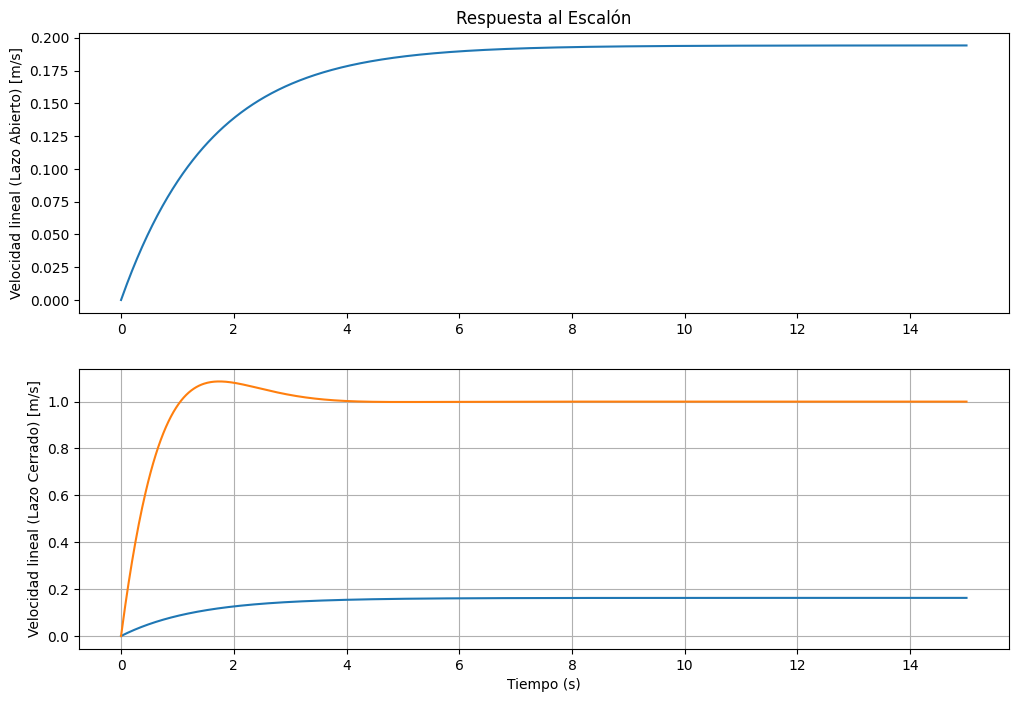

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
import math
from scipy.optimize import minimize

# Parámetros del motor en SI
R = 0.628                # Ohm                 --> R   = resistencia en bornes
L = 0.10 * (10**(-3))    # mH a H              --> L   = inductancia en bornes
Jm = 6.02 * (10**(-6))   # g*cm^2 a kg*m^2     --> Jm  = inercia del rotor
B = 10**(-5)             # N*m*rad/s           --> B   = fricción mecánica
k1 = 25.5 * (10**(-3))   # mV*s/rad a V*s/rad  --> k1  = constante de FEM
k2 = 25.5 * (10**(-3))   # mN*m/A a N*m/A      --> k2  = constante de par
n = 1/10                 #                     --> n   = relacion de transmision


# Parámetros de la cinta, rodillos y carga
Radio_Rodillos = 0.05                           # m         --> Diametro de cada rodillo (x2)
Masa_Rodillos = 0.35                              # Kg        --> Masa de cada rodillo
Longitud_Cinta = 10 + Radio_Rodillos * math.pi     # m         --> Longitud cinta, ida y vuelta
Ancho_Cinta = 0.7                                # m         --> Ancho de la cinta
Densidad_Cinta = 2.3                             #Kg/m^3    --> Densidad especifica del material de la cinta
Area_Cinta = Longitud_Cinta*Ancho_Cinta           # m^2       --> Area de la cinta, ida y vuelta
Masa_Cinta = Area_Cinta*Densidad_Cinta            # Kg        --> Masa de la cinta
Carga = 50                                       # Kg        --> Carga en la cinta transportadora

# Calculos sin carga (cinta + rodillos + transmision)
MOI_rollers = (1/4) * Masa_Rodillos * (Radio_Rodillos**2) * 2   # Kg*m^2    --> Momento de inercia de los rodillos (x2)
MOI_object = (Masa_Cinta + Carga) * (Radio_Rodillos**2)         # Kg*m^2    --> Momento de inercia de la cinta
MOI_gearbox = 6.3 * (10**(-5))                                  # Kg*m^2    --> Momento de inercia de la caja de cambios, le cambie 4 por un 5 para que no tenga tanto peso

# Calculos con carga (cinta + rodillos + transmision + carga)
MOI_sumatoria = MOI_rollers + MOI_object + MOI_gearbox
Jcarga = (n**2) * MOI_sumatoria

# Calculos finales
Jeq = (Jm + Jcarga)
Beq = B

# Definicion de constantes
A = Jeq*L
B = (R*Jeq) + (Beq*L)
C = (R*Beq) + (k1*k2)
D = k2 * Radio_Rodillos * n

# Función de transferencia de la planta
s = ctrl.TransferFunction.s
Gp = D / ((A*s**2) + (B*s) + C)

# Obtener los polos de Gp
poles = ctrl.poles(Gp)
print("Polo 1 de Gp:", poles[0])
print("Polo 2 de Gp:", poles[1])

# Tiempos para simular
t = np.linspace(0, 15, 1000)

# Respuesta al escalón en LA
t, y_open_loop = ctrl.step_response(Gp, t)

# Sistema en lazo cerrado con H(s)=1
Gcl = ctrl.feedback(Gp)
poles = ctrl.poles(Gcl)
print("Polo 1 de Gcl:", poles[0])
print("Polo 2 de Gcl:", poles[1])

# Sistema en lazo cerrado con controlador PID
Kp = 15
Ki = 20
Kd = 0
C = ctrl.TransferFunction([Kd, Kp, Ki], [1, 0])
G_PID = ctrl.feedback(C * Gp, 1)

# Parametros caracteristicos 2do orden
omega = (poles[0]*poles[1])**(1/2)
sita  = abs(poles[0]+poles[1]) / (2*omega)
print("Omega:", omega)
print("sita:", sita)

# Respuesta al escalón en LC
t, y_closed_loop = ctrl.step_response(Gcl, t)

# Respuesta al escalón PID
t, y_PID = ctrl.step_response(G_PID, t)

# Respuestas en función del tiempo
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t, y_open_loop)
plt.title('Respuesta al Escalón')
plt.ylabel('Velocidad lineal (Lazo Abierto) [m/s]')

plt.subplot(2, 1, 2)
plt.plot(t, y_closed_loop)
plt.ylabel('Velocidad lineal (Lazo Cerrado) [m/s]')
plt.xlabel('Tiempo (s)')

plt.subplot(2, 1, 2)
plt.plot(t, y_PID)
plt.ylabel('Velocidad lineal (Lazo Cerrado) [m/s]')
plt.xlabel('Tiempo (s)')

# Gráfica del LGR
#plt.figure(figsize=(8, 6))
#ctrl.root_locus(Gp, plot=True, grid=True)
#plt.title('Lugar Geométrico de las Raíces')
plt.grid(True)
plt.show()